# driftax — Conditional inverse problem on a ring (bimodal posterior)

We train a conditional generator **x ~ qθ(x | y)** where:
- **x** is a 2D point on a noisy ring
- **y** is a 1D measurement: the x-coordinate (with heteroscedastic noise)

Conditioning on y yields a **bimodal** posterior (upper/lower arc).

This notebook:
1) plots the training dataset (x, y)
2) trains DiT1D (sequence length 2) with drifting loss
3) visualizes conditional samples for a few y values


In [1]:
import os, sys

# Driftax notebook backend policy:
# - macOS: FORCE CPU (avoid Metal instability)
# - other OS: let JAX auto-select (GPU if available; else CPU)
#
# NOTE: must run BEFORE importing jax.
for k in ("JAX_PLATFORMS", "JAX_PLATFORM_NAME"):
    os.environ.pop(k, None)

if sys.platform == "darwin":
    os.environ["JAX_PLATFORMS"] = "cpu"


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

from driftax.datasets import inverse_ring_toy
from driftax.dit1d import DiT1D, DiT1DConfig
from driftax.conditioning import CondMLP
from driftax.drift import drifting_loss_features

print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0)]


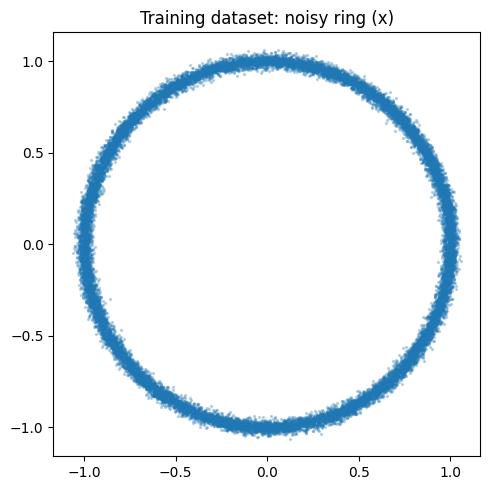

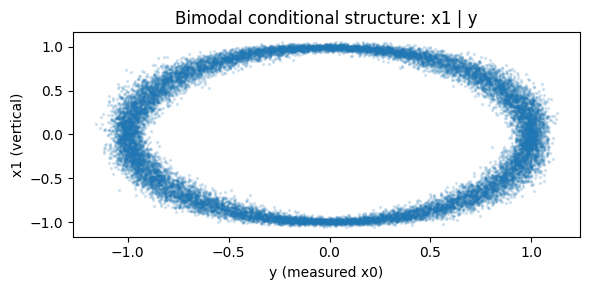

In [3]:
# Plot dataset snapshot
key = jax.random.PRNGKey(0)
x, y = inverse_ring_toy(key, 20000)
x = np.array(x)
y = np.array(y).squeeze(-1)

plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2, alpha=0.25)
plt.axis("equal")
plt.title("Training dataset: noisy ring (x)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.scatter(y, x[:,1], s=2, alpha=0.15)
plt.xlabel("y (measured x0)")
plt.ylabel("x1 (vertical)")
plt.title("Bimodal conditional structure: x1 | y")
plt.tight_layout()
plt.show()


step    1 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=4.742e-03 (ema 4.742e-03)  |x0-y|=6.630e-01 (ema 6.630e-01)  |r-1|=3.996e-01 (ema 3.996e-01)


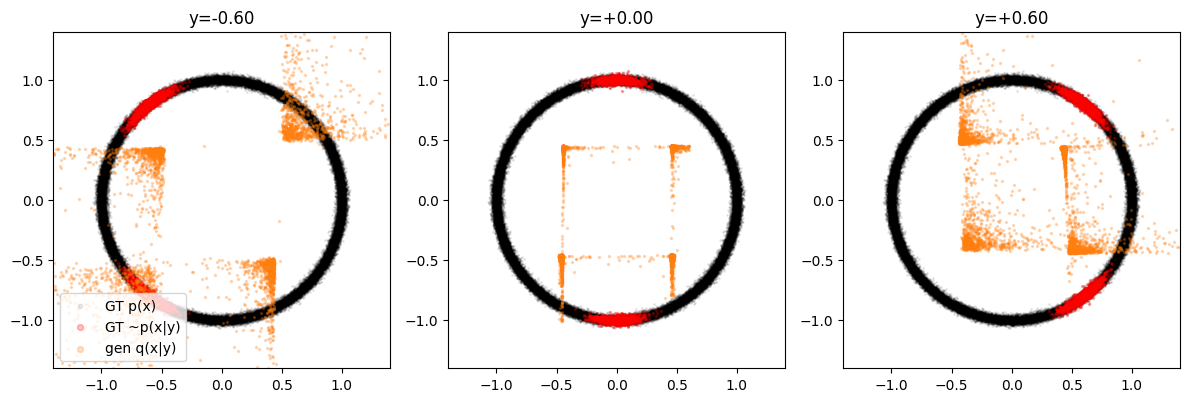

step  500 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=1.225e-02 (ema 7.812e-03)  |x0-y|=2.678e-01 (ema 2.560e-01)  |r-1|=1.164e-01 (ema 1.127e-01)


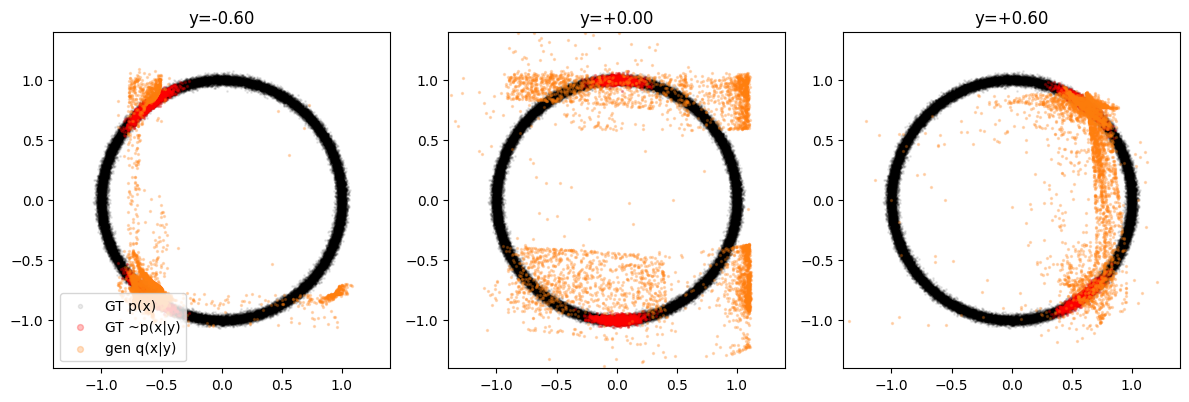

step 1000 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=2.498e-03 (ema 2.715e-03)  |x0-y|=1.432e-01 (ema 1.508e-01)  |r-1|=6.983e-02 (ema 6.780e-02)


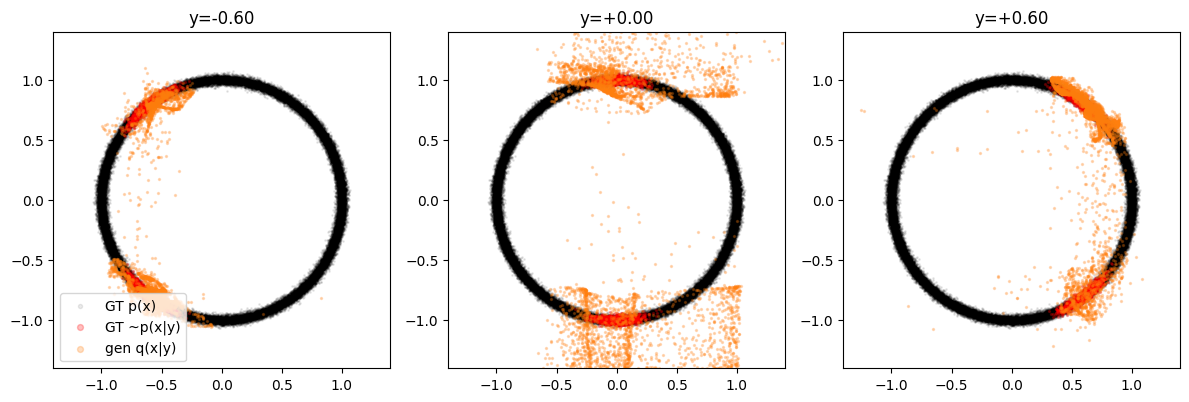

step 1500 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=8.476e-04 (ema 1.055e-03)  |x0-y|=9.729e-02 (ema 9.281e-02)  |r-1|=4.550e-02 (ema 4.264e-02)


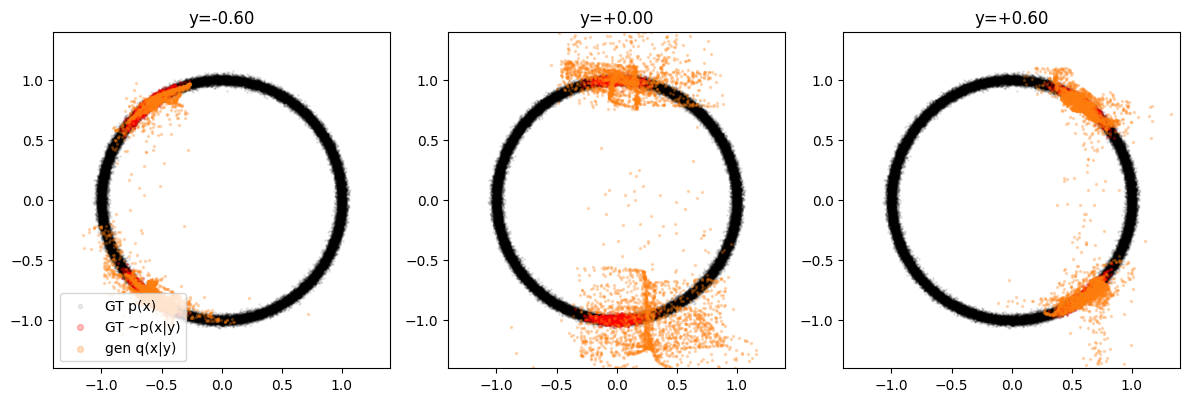

step 2000 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=1.044e-03 (ema 5.065e-04)  |x0-y|=1.063e-01 (ema 1.048e-01)  |r-1|=5.147e-02 (ema 4.878e-02)


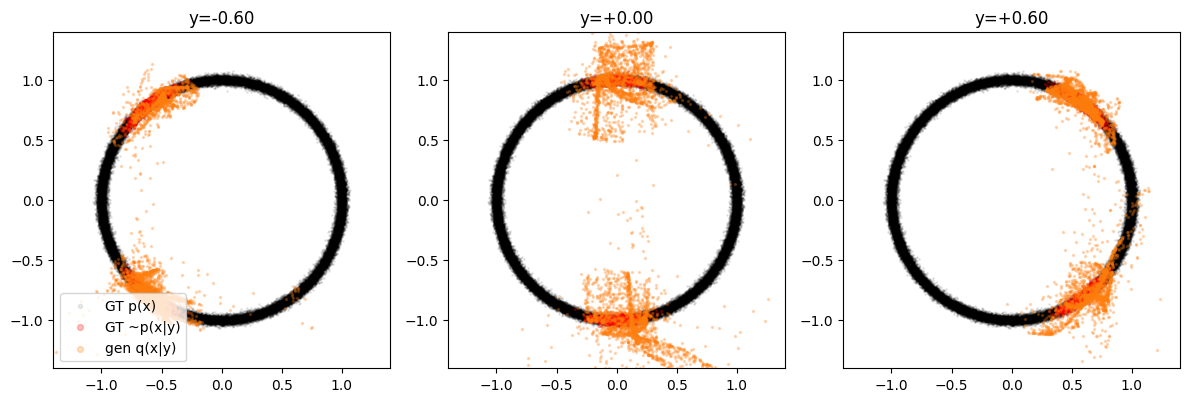

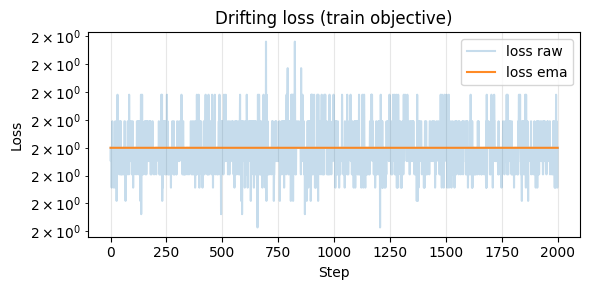

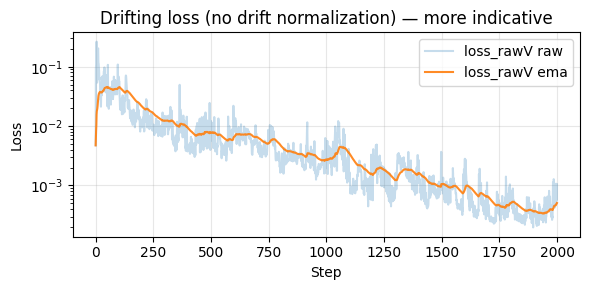

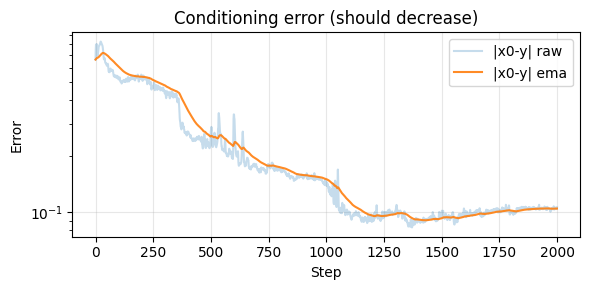

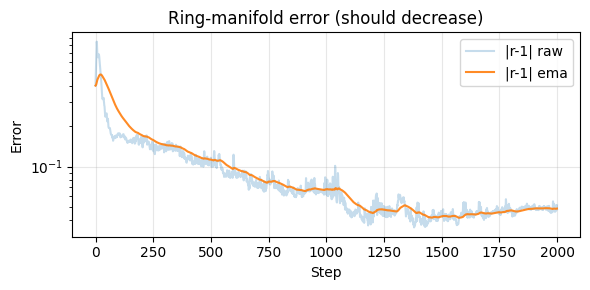

In [ ]:
# Train DiT1D on ring conditional 
cfg = DiT1DConfig(length=2, patch=1, dim=256, depth=6, heads=4, cond_dim=256, drop=0.0)
model = DiT1D(cfg)
cond_net = CondMLP(in_dim=1, out_dim=cfg.cond_dim, hidden=256)


batch      = 512
POOL       = 4096
steps      = 2000
plot_every = 500

temps_x = (0.05,)     
TEMP_Y  = 0.05
BETA_Y  = 3.0

lr        = 1e-4
CLIP_NORM = 1.0

# plotting
Y0_LIST    = (-0.6, 0.0, 0.6)
N_GT_PLOT  = 80000
N_GEN_PLOT = 4000
SLICE_TOL  = 0.05


key = jax.random.PRNGKey(1)
key, k1, k2 = jax.random.split(key, 3)

dummy_noise = jnp.zeros((1, 2), dtype=jnp.float32)
dummy_y     = jnp.zeros((1, 1), dtype=jnp.float32)

cond_params  = cond_net.init(k1, dummy_y)
cond0        = cond_net.apply(cond_params, dummy_y)
model_params = model.init(k2, dummy_noise, cond0, train=True)

params = {"cond": cond_params, "model": model_params}

opt = optax.chain(
    optax.clip_by_global_norm(CLIP_NORM),
    optax.adamw(lr, weight_decay=1e-4),
)
opt_state = opt.init(params)


def _cdist_l2(a, b):
    a2 = jnp.sum(a * a, axis=1, keepdims=True)
    b2 = jnp.sum(b * b, axis=1, keepdims=True).T
    return jnp.sqrt(jnp.maximum(a2 + b2 - 2.0 * (a @ b.T), 0.0) + 1e-12)

def _softmax2d_rowcol(logits):
    K = jnp.exp(logits - jnp.max(logits, axis=1, keepdims=True))
    row = jnp.sum(K, axis=1, keepdims=True)
    col = jnp.sum(K, axis=0, keepdims=True)
    norm = jnp.sqrt(jnp.maximum(row * col, 1e-12))
    return K / norm

def _normalize_features(x, targets):
    scale = jnp.sqrt(jnp.mean(targets * targets) + 1e-12)
    scale = jax.lax.stop_gradient(scale)
    return x / scale, targets / scale

def _normalize_drift(V):
    s = jnp.sqrt(jnp.mean(V * V) + 1e-12)
    return V / s

def compute_V_conditional(x, y, pos_x, pos_y, neg_x, neg_y, temp_x, temp_y, beta_y=1.0):
    dx_pos = _cdist_l2(x, pos_x)
    dx_neg = _cdist_l2(x, neg_x)
    dy_pos = _cdist_l2(y, pos_y)
    dy_neg = _cdist_l2(y, neg_y)

    # mask self when neg == x
    n = x.shape[0]
    if neg_x.shape[0] >= n:
        big = jnp.eye(n, dtype=dx_neg.dtype) * 1e6
        dx_neg = dx_neg.at[:, :n].add(big)
        dy_neg = dy_neg.at[:, :n].add(big)

    logits_pos = -(dx_pos / temp_x + beta_y * (dy_pos / temp_y))
    logits_neg = -(dx_neg / temp_x + beta_y * (dy_neg / temp_y))
    logits = jnp.concatenate([logits_pos, logits_neg], axis=1)

    A = _softmax2d_rowcol(logits)
    P = pos_x.shape[0]
    A_pos = A[:, :P]
    A_neg = A[:, P:]

    W_pos = A_pos * jnp.sum(A_neg, axis=1, keepdims=True)
    W_neg = A_neg * jnp.sum(A_pos, axis=1, keepdims=True)

    return (W_pos @ pos_x) - (W_neg @ neg_x)

def drifting_loss_conditional_features(
    x_feat, y, pos_feat, pos_y,
    temps_x=(0.05,), temp_y=0.05, beta_y=3.0,
    feature_normalize=True, drift_normalize=True,
):
    neg_feat = x_feat
    neg_y = y

    if feature_normalize:
        targets = jnp.concatenate([pos_feat, neg_feat], axis=0)
        x_n, targets_n = _normalize_features(x_feat, targets)
        pos_n = targets_n[:pos_feat.shape[0]]
        neg_n = targets_n[pos_feat.shape[0]:]
    else:
        x_n, pos_n, neg_n = x_feat, pos_feat, neg_feat

    Vs = []
    for Tx in temps_x:
        Vs.append(compute_V_conditional(
            x_n, y,
            pos_n, pos_y,
            neg_n, neg_y,
            temp_x=float(Tx),
            temp_y=float(temp_y),
            beta_y=float(beta_y),
        ))
    V = sum(Vs) / float(len(Vs))

    if drift_normalize:
        V = _normalize_drift(V)

    target = jax.lax.stop_gradient(x_n + V)
    return jnp.mean(jnp.sum((x_n - target) ** 2, axis=-1))


def loss_and_metrics(params, key):
    key, kpool, ky, kz = jax.random.split(key, 4)

    # paired positives pool
    pos_x, pos_y = inverse_ring_toy(kpool, POOL)  # [POOL,2], [POOL,1]

    # sample y inputs uniformly (inverse-problem conditioning inputs)
    y_in = jax.random.uniform(ky, (batch, 1), minval=-1.0, maxval=1.0, dtype=jnp.float32)
    c = cond_net.apply(params["cond"], y_in)

    # generate x|y
    z = jax.random.normal(kz, (batch, 2), dtype=jnp.float32)
    x_gen = model.apply(params["model"], z, c, train=True)

    # training loss (normalized drift)
    loss = drifting_loss_conditional_features(
        x_feat=x_gen, y=y_in,
        pos_feat=pos_x, pos_y=pos_y,
        temps_x=temps_x,
        temp_y=TEMP_Y,
        beta_y=BETA_Y,
        feature_normalize=True,
        drift_normalize=True,
    )

    # logging loss without drift normalization 
    loss_rawV = drifting_loss_conditional_features(
        x_feat=x_gen, y=y_in,
        pos_feat=pos_x, pos_y=pos_y,
        temps_x=temps_x,
        temp_y=TEMP_Y,
        beta_y=BETA_Y,
        feature_normalize=True,
        drift_normalize=False,
    )

    # metrics that should trend
    cond_err = jnp.mean(jnp.abs(x_gen[:, 0] - y_in[:, 0]))  # enforce x0 ~ y
    r = jnp.sqrt(jnp.sum(x_gen * x_gen, axis=1) + 1e-12)
    ring_err = jnp.mean(jnp.abs(r - 1.0))                   # enforce radius ~ 1

    return loss, (loss_rawV, cond_err, ring_err)

@jax.jit
def step_fn(params, opt_state, key):
    (loss, (loss_rawV, cond_err, ring_err)), grads = jax.value_and_grad(
        lambda p: loss_and_metrics(p, key), has_aux=True
    )(params)
    updates, opt_state2 = opt.update(grads, opt_state, params)
    params2 = optax.apply_updates(params, updates)
    return params2, opt_state2, key, loss, loss_rawV, cond_err, ring_err


def conditional_plot(params, y0_list=Y0_LIST, n_gen=N_GEN_PLOT, tol=SLICE_TOL):
    k = jax.random.PRNGKey(123)
    x_true, y_true = inverse_ring_toy(k, N_GT_PLOT)
    xt = np.array(x_true)
    yt = np.array(y_true).squeeze(-1)

    fig, axes = plt.subplots(1, len(y0_list), figsize=(4 * len(y0_list), 4), sharex=False, sharey=False)
    if len(y0_list) == 1:
        axes = [axes]

    for i, (ax, y0) in enumerate(zip(axes, y0_list)):
        ax.scatter(xt[:, 0], xt[:, 1], s=1, alpha=0.08, c="black", label="GT p(x)" if i == 0 else None)

        m = np.abs(yt - y0) < tol
        ax.scatter(xt[m, 0], xt[m, 1], s=2, alpha=0.25, c="red", label="GT ~p(x|y)" if i == 0 else None)

        y_in = jnp.full((n_gen, 1), float(y0), dtype=jnp.float32)
        c = cond_net.apply(params["cond"], y_in)
        kgen = jax.random.PRNGKey(1000 + i)
        z = jax.random.normal(kgen, (n_gen, 2), dtype=jnp.float32)
        xg = np.array(model.apply(params["model"], z, c, train=False))

        ax.scatter(xg[:, 0], xg[:, 1], s=2, alpha=0.25, c="tab:orange", label="gen q(x|y)" if i == 0 else None)

        ax.set_title(f"y={y0:+.2f}")
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-1.4, 1.4)
        ax.set_ylim(-1.4, 1.4)

    axes[0].legend(loc="lower left", markerscale=3)
    fig.tight_layout()
    plt.show()


loss_hist, ema_loss_hist = [], []
raw_hist,  ema_raw_hist  = [], []
cond_hist, ema_cond_hist = [], []
ring_hist, ema_ring_hist = [], []

ema_loss = ema_raw = ema_cond = ema_ring = None

for s in range(1, steps + 1):
    params, opt_state, key, loss, loss_rawV, cond_err, ring_err = step_fn(params, opt_state, key)

    lv  = float(loss)
    rv  = float(loss_rawV)
    cv  = float(cond_err)
    rg  = float(ring_err)

    loss_hist.append(lv); raw_hist.append(rv); cond_hist.append(cv); ring_hist.append(rg)

    ema_loss = lv if ema_loss is None else 0.98 * ema_loss + 0.02 * lv
    ema_raw  = rv if ema_raw  is None else 0.98 * ema_raw  + 0.02 * rv
    ema_cond = cv if ema_cond is None else 0.98 * ema_cond + 0.02 * cv
    ema_ring = rg if ema_ring is None else 0.98 * ema_ring + 0.02 * rg

    ema_loss_hist.append(ema_loss)
    ema_raw_hist.append(ema_raw)
    ema_cond_hist.append(ema_cond)
    ema_ring_hist.append(ema_ring)

    if s == 1 or (plot_every and s % plot_every == 0) or s == steps:
        print(
            f"step {s:4d} "
            f"loss={lv:.3e} (ema {ema_loss:.3e})  "
            f"loss_rawV={rv:.3e} (ema {ema_raw:.3e})  "
            f"|x0-y|={cv:.3e} (ema {ema_cond:.3e})  "
            f"|r-1|={rg:.3e} (ema {ema_ring:.3e})"
        )
        conditional_plot(params)


loss_hist = np.asarray(loss_hist, dtype=np.float32)
raw_hist  = np.asarray(raw_hist,  dtype=np.float32)
cond_hist = np.asarray(cond_hist, dtype=np.float32)
ring_hist = np.asarray(ring_hist, dtype=np.float32)

ema_loss_hist = np.asarray(ema_loss_hist, dtype=np.float32)
ema_raw_hist  = np.asarray(ema_raw_hist,  dtype=np.float32)
ema_cond_hist = np.asarray(ema_cond_hist, dtype=np.float32)
ema_ring_hist = np.asarray(ema_ring_hist, dtype=np.float32)

# plt.figure(figsize=(6,3))
# plt.plot(loss_hist, alpha=0.25, label="loss raw")
# plt.plot(ema_loss_hist, alpha=0.9, label="loss ema")
# plt.yscale("log"); plt.grid(True, alpha=0.3)
# plt.xlabel("Step"); plt.ylabel("Loss")
# plt.title("Drifting loss (train objective)")
# plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(raw_hist, alpha=0.25, label="loss_rawV raw")
plt.plot(ema_raw_hist, alpha=0.9, label="loss_rawV ema")
plt.yscale("log"); plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("Drifting loss (no drift normalization) — more indicative")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(cond_hist, alpha=0.25, label="|x0-y| raw")
plt.plot(ema_cond_hist, alpha=0.9, label="|x0-y| ema")
plt.yscale("log"); plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Error")
plt.title("Conditioning error (should decrease)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(ring_hist, alpha=0.25, label="|r-1| raw")
plt.plot(ema_ring_hist, alpha=0.9, label="|r-1| ema")
plt.yscale("log"); plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Error")
plt.title("Ring-manifold error (should decrease)")
plt.legend(); plt.tight_layout(); plt.show()